# Parametric Simulation: Weibull with Simple Linear Predictor

Setup chunk:

In [2]:
import numpy as np
from scipy.stats import weibull_min # r weibull simulation
from scipy.stats import norm # for covariate simulation
from scipy.stats import gamma # for weibull shape parameter
from scipy.stats import bernoulli # for censoring
from scipy.stats import uniform
from scipy.stats.mstats import mquantiles
import pandas as pd

## Simulated data
In this section, we define and check a function to simulate survival data from a Weibull distribution using a simple linear predictor given by:
\begin{equation}
  t_i \sim \text{Weib}(\kappa,\lambda e^{x_i ^T \beta});
\end{equation}
\begin{equation}
  \lambda = 1, \quad \kappa = 5;
\end{equation}
\begin{equation}
  \beta = (\beta_1,\dots,\beta_p)^T \in \mathbb{R}^p \text{ (chosen)};
\end{equation}
\begin{equation}
    x_i = (x_i,\dots, x_p)^T \in \mathbb{R}^p,
\end{equation}
\begin{equation}
  x_{i,j} \sim \mathcal{N}(0,1) \text{ for } j = 1, \dots, p_\text{cont}, \quad x_{i,j} \sim \text{Bernoulli}(\pi_j) \text{ for } j = 1, \dots, p_\text{cat}.
\end{equation}
Censoring is modelled by:
- *Simulate end of follow-up period:* $p_\text{dropout} = 0.2$.  $q = \frac{1 - p_\text{censor}}{1 - p_\text{dropout} p_\text{censor}}$. If $\hat{F}(t_i) > q$, set $t_i \rightarrow t_i^\prime F^-(q)$. (I.e. set all times above $q$th quantile to $q$th quantile.)
-*Simulate random drop-out:* If $\hat{F}(t_i) <= q$, let $d_i \sim \text{Bern}(p_\text{dropout} p_\text{censor})$ be the indicator variable for dropping out. If $\delta_i = 1$, then $t_i \rightarrow t_i^\prime \sim \mathcal{U}(0,t_i)$.

Note that the `scipy.stats.weibull_min` uses the parameterisation of the Weibull distribution:
\begin{align}
f(t) = \frac{k}{l}(\frac{t}{l})^{k - 1} e^{-(t/l)^k}.
\end{align}
Hence, we set $k = \kappa$ and $l =  e^{-x_i^T \beta/k}$.

### Simultion function

In [3]:
def weibull_simple_linear_sim(betas, prop_cat, obs, censor_prop, pi = 0.5):
    # Simulate survival times from a Weibull simulation with linear predictor.
    
    # betas: predictors
    # prop_cat: approximate proportion of the variables that will be categorical, determining p_cont and p_cat
    # obs: number of observations to simulate
    # censor_prop: proportion of individuals to censored
    # show_beta: prints the linear coefficients used in the simulation (for testing function)
    # pi: probabilities for simulating the probabilities in the Bernoulli disribution for the categorical variables
    
    n_beta = len(betas)
    # matrix of normal covariates
    X_norm = norm.rvs(size = obs*int(np.floor(n_beta*(1-prop_cat)))).reshape((obs,int(np.floor(n_beta*(1-prop_cat)))))
    # matrix of categorical covariates
    X_cat = bernoulli.rvs(p = pi, size = obs*int(np.ceil(n_beta*(prop_cat)))).reshape((obs,int(np.ceil(n_beta*(prop_cat)))))
    X = np.hstack([X_norm,X_cat])
    
    # shape parameter of weibull
    c = 5
    
    # calculating linear predictor
    lin_pred = np.matmul(X,betas) 
    
    # creating a dataframe for the simulation
    sim_data = pd.DataFrame(X)
    # simulating survival times from weibull distribution
    sim_data["y"] = weibull_min.rvs(c, scale = np.exp(-lin_pred/c)) 

    # proportion of censors caused by dropping out
    dropout_prop = 0.2
    # quantile above which we censor
    max_time = float(mquantiles(sim_data["y"], prob = (1 - censor_prop)/(1 - dropout_prop*censor_prop)))
    # censoring indicator invdividuals above the quantile
    sim_data["end_censor"] = np.where(sim_data["y"] > max_time,True,False)
    # dropout indicator for individuals not censored by end censoring
    sim_data["dropout"] = np.where(sim_data["end_censor"] == False, bernoulli.rvs(p = dropout_prop*censor_prop, size = len(sim_data)) == 1, False)
    # "end censoring" times
    sim_data["end_censor_time"] = np.where(sim_data["y"] > max_time, max_time, sim_data["y"])
    # simulating the dropout time
    sim_data["time"] = np.where(sim_data["dropout"], uniform.rvs(scale = sim_data["end_censor_time"]), sim_data["end_censor_time"])

    sim_data["event"] = ~(sim_data["dropout"] | sim_data["end_censor"]) 
    
    return(sim_data)

Example output:

In [4]:
test = weibull_simple_linear_sim([1,1,1,1,1,1,1,1,1,1], 0.5, 10, 0.7, pi = 0.5)
test

,0,1,2,3,4,5,6,7,8,9,y,end_censor,dropout,end_censor_time,time,event
0,0.480447,-1.473400,-0.299534,-0.364364,-0.201604,0.0,0.0,1.0,0.0,1.0,0.870447,True,False,0.438146,0.438146,False
1,0.235911,0.174296,1.475699,0.044253,-0.210214,0.0,0.0,1.0,0.0,1.0,0.472693,True,False,0.438146,0.438146,False
2,-1.270832,0.740880,2.726434,0.647427,0.927893,1.0,1.0,1.0,1.0,1.0,0.139232,False,False,0.139232,0.139232,True
3,2.751333,-0.494926,1.187219,1.180480,0.967087,1.0,1.0,1.0,0.0,0.0,0.145369,False,True,0.145369,0.045749,False
4,0.522937,-1.393444,-0.011573,-0.294383,-1.308031,0.0,1.0,1.0,1.0,1.0,0.547683,True,False,0.438146,0.438146,False
5,1.353294,-0.423061,0.079147,-0.452802,-0.799412,0.0,1.0,0.0,1.0,0.0,0.515182,True,False,0.438146,0.438146,False
6,-0.343555,-0.598013,0.775104,0.946112,-0.988989,1.0,1.0,1.0,1.0,0.0,0.438865,True,False,0.438146,0.438146,False
7,0.453364,0.011301,-0.238252,-0.935642,1.116271,1.0,0.0,0.0,0.0,1.0,0.523027,True,False,0.438146,0.438146,False
8,0.275505,0.101089,-0.636814,-0.501256,-1.376682,0.0,1.0,1.0,0.0,0.0,0.945928,True,False,0.438146,0.438146,False
9,-0.191046,-0.650079,-0.267170,-0.285925,1.563557,0.0,1.0,1.0,1.0,1.0,0.421684,False,False,0.421684,0.421684,True


### Tests

From a cursory look at the output, we can see that there are 10 covariates, half of which are categorical and half normal. If the subject does not drop out, then the drop out time is the same as y, and that if the time is end censored then it is set to this maximum time.

Let us check that the number of events is as expected:

In [6]:
n_events_samp = [sum(weibull_simple_linear_sim([1,1,1,1,1,1,1,1,1,1], 0.5, 1000, 0.7, pi = 0.5)["event"] == False)/1000 for i in range(1000)]
np.mean(n_events_samp), np.std(n_events_samp)

(0.7001479999999999, 0.006309365736744067)

We expect 0.7 of the events to be censored so this result is consistent.

Checking that the proportion of categorical and normal variables works with non-comensurate proportions:

In [8]:
weibull_simple_linear_sim([1,1,1,1,1,1,1], 0.28, 10, 0.7, pi = 0.5)

,0,1,2,3,4,5,6,y,end_censor,dropout,end_censor_time,time,event
0,2.184234,0.125327,0.413318,0.481239,1.414663,0.0,1.0,0.326473,False,False,0.326473,0.326473,True
1,-1.781990,0.832464,-0.033117,0.330981,-1.347186,0.0,0.0,1.726435,True,False,0.631931,0.631931,False
2,-0.549977,2.197239,-1.706699,0.847976,-0.831545,0.0,1.0,0.627424,False,False,0.627424,0.627424,True
3,-3.123806,0.025018,-1.290282,-1.008422,0.460032,0.0,0.0,2.195537,True,False,0.631931,0.631931,False
4,0.302392,1.264318,-0.147885,-1.015090,-0.435808,0.0,1.0,0.617931,False,False,0.617931,0.617931,True
5,0.569076,0.312382,0.566708,1.051376,-1.711078,1.0,0.0,0.632128,True,False,0.631931,0.631931,False
6,-0.775741,-0.806749,0.236329,-1.904325,0.369993,0.0,0.0,1.087253,True,False,0.631931,0.631931,False
7,-1.209805,-0.947537,0.037008,-0.105974,0.284405,1.0,1.0,0.998714,True,False,0.631931,0.631931,False
8,-0.577446,0.609382,-0.064229,-0.760053,0.226761,0.0,1.0,0.952173,True,False,0.631931,0.631931,False
9,-0.117065,0.262761,-1.278873,0.869169,0.879420,0.0,0.0,0.834960,True,False,0.631931,0.631931,False


Now we can check if the generation process by setting just one covariate and plotting the distribution of the surival times:

We set the single variable to categorical with probability 1 of occuring and the censoring probability to 0, so we should just get a simple Weibull distribution.

In [11]:
from matplotlib import pyplot as plt
import random

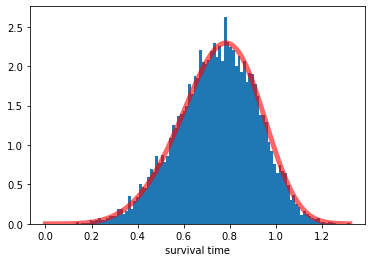

In [12]:
sample = weibull_simple_linear_sim([1], 1, 10000, 0.0, pi = 1)

x = np.linspace(0,max(sample["time"]),100)

fig,ax = plt.subplots(1,1)
a = sample["time"]
ax.hist(a,bins = 100, density = True)
ax.plot(x, weibull_min.pdf(x, 5, scale = np.exp(-1/5)),
       'r-', lw=5, alpha=0.6, label='weibull_min pdf')
ax.set_xlabel('survival time')
plt.show()

Now if we have some censoring, you can see the distribution is "cut off":

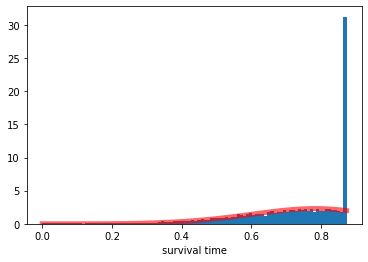

In [13]:
sample = weibull_simple_linear_sim([1], 1, 10000, 0.3, pi = 1)

x = np.linspace(0,max(sample["time"]),100)

fig,ax = plt.subplots(1,1)
a = sample["time"]
ax.hist(a,bins = 100, density = True)
ax.plot(x, weibull_min.pdf(x, 5, scale = np.exp(-1/5)),
       'r-', lw=5, alpha=0.6, label='weibull_min pdf')
ax.set_xlabel('survival time')
plt.show()